In [1]:
import os
from magno_tracker.tracking import *
%matplotlib widget

exp = TrackingExperiment('./', remove_incompletes=False)

h:\Other computers\rig 1\pablo\magnocube\mseq_test\magno_tracker\tracking.py:3379: RuntimeWarning: divide by zero encountered in scalar divide
  self.time = self.frame_ind * (1./ self.holocube_framerate)


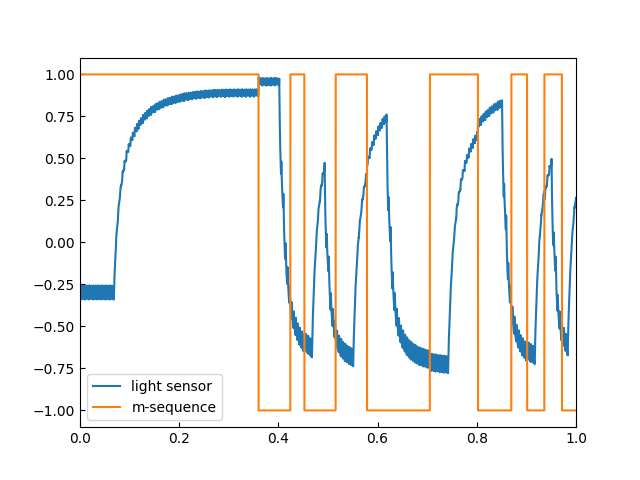

In [ ]:
# grab the first trial
trial = exp.trials[0]
# get the light sensor measurements and the original m-sequence data
daq_data = trial.analog
light_vals, mseq = daq_data[:]
# we need to normalize the msequence to lie between -1 and 1
# first threshold the m-sequence for values above and below 2.5
mseq[mseq < 2.5] = 1
mseq[mseq >= 2.5] = -1
# and remove the mean from the light sensor data
light_vals = light_vals - np.mean(light_vals)

# re-plot the two traces
plt.figure()
xs = np.arange(len(light_vals)) / 100000.
plt.plot(xs, light_vals, label='light sensor')
plt.plot(xs, mseq, label='m-sequence')
plt.xlim(0, 3)
plt.legend()
plt.show()

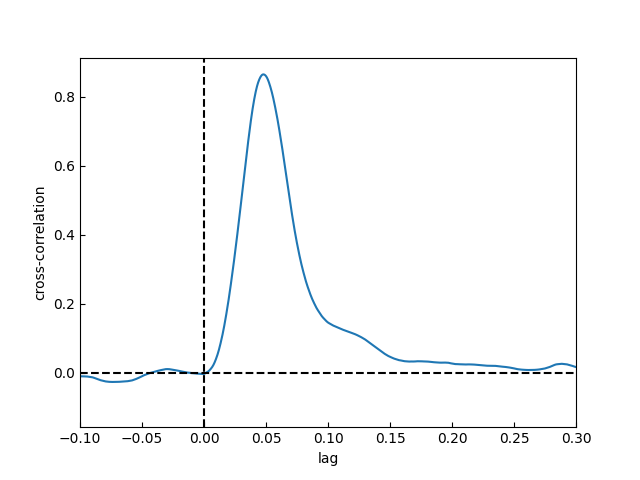

In [3]:
# now, cross-correlate the light sensor data with the m-sequence
corr = scipy.signal.correlate(light_vals, mseq, mode='same')
# normalize the cross-correlation to be a pearson correlation
corr_norm = corr / (np.std(light_vals) * np.std(mseq) * len(light_vals))

lags = np.arange(-len(light_vals)//2, len(light_vals)//2)
# the frame rate is 100000, so let's convert lags to seconds
lags = lags / 100000
# plot the cross-correlation
plt.figure()
plt.plot(lags, corr_norm)
# plot vertical and horizontal lines at 0
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlim(-.1, .3)    
plt.xlabel('lag')
plt.ylabel('cross-correlation')
plt.show()

c:\Users\johnp\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


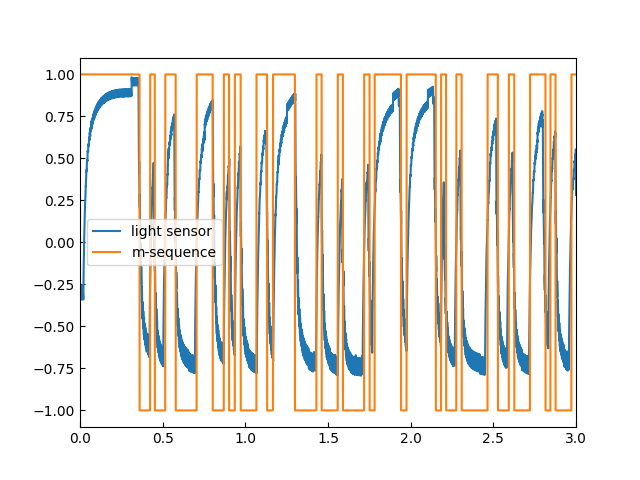

In [4]:
# plot the two signals with the light sensor data shifted by the lag of the peak of the cross-correlation
plt.figure()
lag = lags[np.argmax(abs(corr_norm))]
plt.plot(xs - lag, light_vals, label='light sensor')
plt.plot(xs, mseq, label='m-sequence')
plt.xlim(0, 3)
plt.legend()
plt.show()

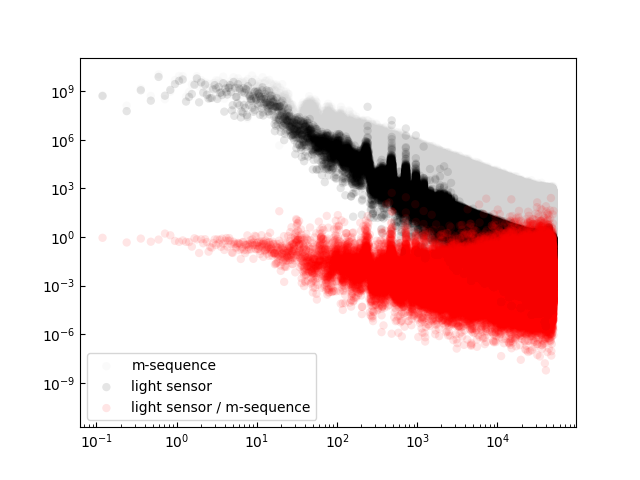

In [5]:
# convolution equates to multiplication in the frequency domain
# because the m-sequence is spectrally flat, we should be able to see the effect
# on the power spectrum of the light sensor data by simply plotting its power spectrum
plt.figure()
# plot the power spectrum of both the m-sequence and the light sensor data
freqs = np.fft.fftfreq(len(light_vals), 1/100000)
ffts = []
for arr, lbl, color, alpha in zip([mseq, light_vals], ['m-sequence', 'light sensor'], ['lightgray', 'k'], [.1, .1]):
    fft = np.fft.fft(arr)
    ffts += [fft]
    psd = np.abs(fft)**2
    # plt.semilogy(freqs, psd, label=lbl, linestyle='none', marker='.', alpha=.1, edgecolors='none')
    plt.scatter(freqs, psd, alpha=alpha, edgecolors='none', label=lbl, color=color)
# now, divide the fft of the light sensor data by the fft of the m-sequence to get the effect of the m-sequence on the power spectrum
psd = np.abs(ffts[1] / ffts[0])**2
plt.scatter(freqs, psd, alpha=.1, edgecolors='none', label='light sensor / m-sequence', color='r')
plt.legend()
plt.semilogy()
plt.semilogx()
plt.show()

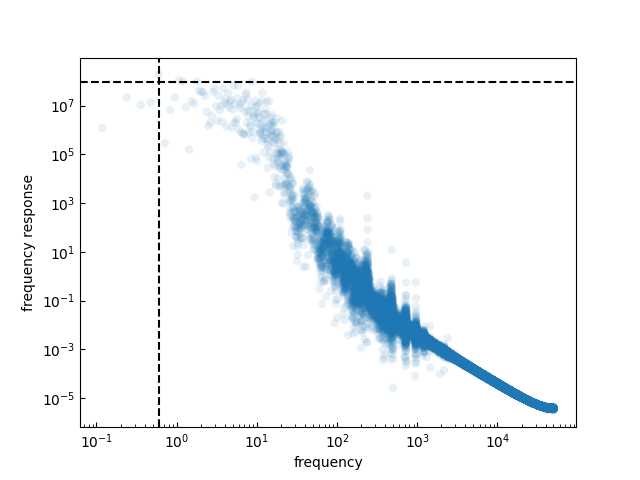

In [6]:
# using the cross-correlation, calculate the frequency response of the system
# we need to normalize the cross-correlation
# get the frequency response
freq_resp = np.fft.fft(corr_norm)
freq_resp = np.abs(freq_resp)**2
# get the x-values
freqs = np.fft.fftfreq(len(corr), 1/100000)
# measure when the frequency response is at half its maximum value
half_max = np.max(freq_resp) / 2
# and which frequency that corresponds to
half_max_freq = np.abs(freqs[freq_resp > half_max][0])
# plot the frequency response
plt.figure()
plt.scatter(freqs, freq_resp, alpha=.1, edgecolors='none')
# plot a horizontal line at half-max
plt.axhline(half_max, color='k', linestyle='--')
# plot a vertical line at the half-max frequency
plt.axvline(half_max_freq, color='k', linestyle='--')
plt.semilogx()
plt.semilogy()
plt.xlabel('frequency')
plt.ylabel('frequency response')
plt.show()

In [ ]:
# deconvonle the light sensor data with the original cross-correlation
# get the deconvolution
include = (lags > 0 ) & (lags < .25)
impulse = corr[include]
impulse /= impulse.sum()
# now, let's bin average the two signals
bin_size = 100
light_vals_lq = np.mean(light_vals[:len(light_vals) // bin_size * bin_size].reshape(-1, bin_size), axis=1)
impulse_lq = np.mean(impulse[:len(impulse) // bin_size * bin_size].reshape(-1, bin_size), axis=1)
deconv = scipy.signal.deconvolve(light_vals_lq, impulse_lq)
# # get the deconvolved signal
# deconv_signal = deconv[0]
# # plot the deconvolved signal
# plt.figure()
# plt.plot(deconv_signal)
# # plt.ylim(-5, 5)
# plt.show()
